In [183]:
#Data manipulation and visualization
#from datamata import *
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from bokeh.plotting import figure, output_file, show

from glob import glob
#ML models
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

#import parfit.parfit as pf
#Logit and OLS
from statsmodels.discrete.discrete_model import Logit
from statsmodels.formula.api import ols
from statsmodels.api import qqplot
import statsmodels.stats as sms
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.stats.diagnostic import het_breuschpagan
#Statistics
from scipy import stats
from scipy.stats import shapiro
#Neural Net
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

## Data importing

In [4]:
"""files = glob("*.csv")
data = pd.Dataframe()
for file in files:
    next_data = pd.read_csv(file)
    data = pd.concat([data, next_data], axis=0)
print(data.shape)
data.head()"""

'files = glob("*.csv")\ndata = pd.Dataframe()\nfor file in files:\n    next_data = pd.read_csv(file)\n    data = pd.concat([data, next_data], axis=0)\nprint(data.shape)\ndata.head()'

In [93]:
#base_data = pd.read_csv("kaggle datasets download -d kemical/kickstarter-projects")
base_data = pd.read_csv("ks-projects-201801.csv")

In [94]:
base_data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


## Data Cleaning and EDA

In [7]:
base_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [95]:
#missing values
print("Percent of missing values in variables.")
miss_perc = pd.DataFrame({
    "Amount": base_data.isnull().sum(), 
    "Percent": (base_data.isnull().sum() / len(base_data)).round(2) * 100},
    index=base_data.columns).sort_values("Percent", ascending=False)
miss_perc[miss_perc['Amount'] > 0]

Percent of missing values in variables.


,Amount,Percent
usd pledged,3797,1.0
name,4,0.0


In [96]:
#amount of duplicate values in variables
duplicate_perc = (base_data.duplicated(["usd pledged", 
                                        "usd_pledged_real"]).sum() / len(base_data)).round(2) * 100
print("Percent of duplicate values in 'usd pledged' and 'usd_pledged_real' variables:\n", duplicate_perc)

Percent of duplicate values in 'usd pledged' and 'usd_pledged_real' variables:
 61.0


There are 15 columns and 378661 observations in original data.<br>
Let's look through columns and see if they contain missing values and if we can drop them
- ID: we don't need this column, it is unique for each campaign
- name: like ID case it is unique for each row and does not contain information
    - It also has null values
- goal: this column has values that are from different currencies and real value is in usd_goal_real
- pledged: same situation as in goal column
- usd pledged: this one contains many missing values and in some cases the values are wrong calculated
    - The real correctly calculated information is in usd_pledged_real
    
So we need drop these predictors.<br>
For others we need more information

In [10]:
base_data.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


Number of unique values: 159


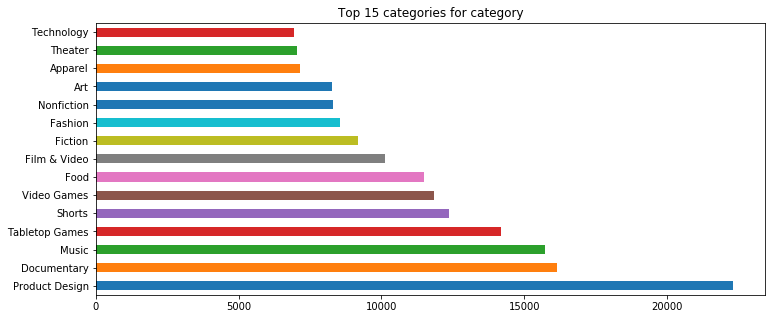

Number of unique values: 15


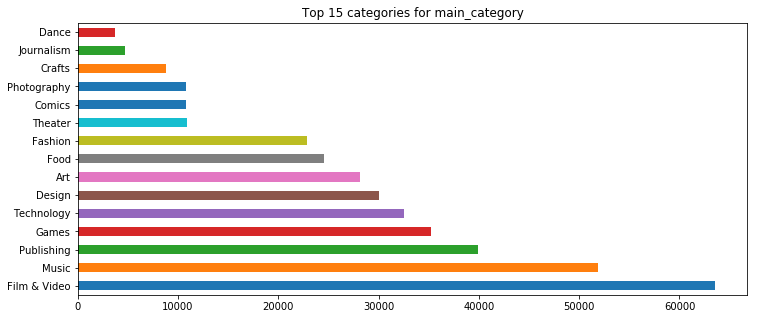

In [11]:
for i in base_data[["category", "main_category"]]:
    number = base_data[i].nunique()
    print("Number of unique values: {}".format(number))
    base_data[i].value_counts().sort_values(ascending=False)[:15].plot(kind="barh",
                                                                       title="Top 15 categories for {}".format(i),
                                                                       figsize=(12,5))
    plt.show()

In [12]:
#checking duplicates in main_category and category variables
base_data.duplicated(["main_category", "category"]).sum()

378491

Number of unique countries: 23


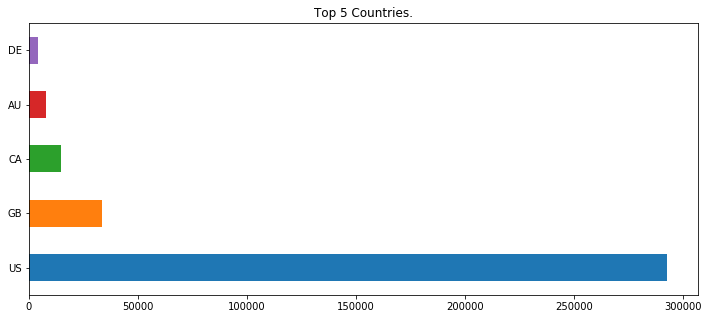

In [13]:
print("Number of unique countries:", base_data.country.nunique())
base_data["country"].value_counts().sort_values(ascending=False)[:5].plot(kind="barh", 
                                                                          title="Top 5 Countries.",
                                                                          figsize=(12, 5))

Number of unique currencies: 14


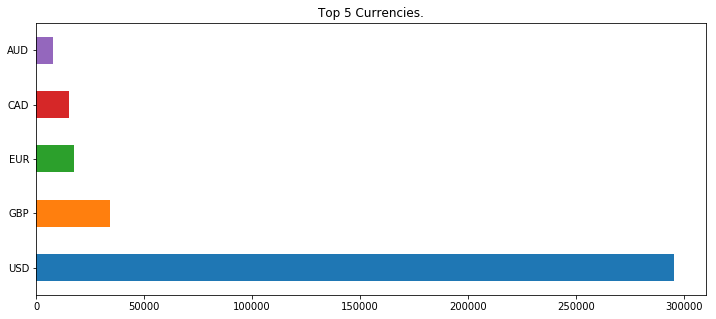

In [14]:
print("Number of unique currencies:", base_data.currency.nunique())
base_data["currency"].value_counts().sort_values(ascending=False)[:5].plot(kind="barh", 
                                                                           title="Top 5 Currencies.",
                                                                           figsize=(12, 5))

In [15]:
pd.crosstab(base_data['country'], base_data['currency'])

currency,AUD,CAD,CHF,DKK,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD
country,,,,,,,,,,,,,,
AT,0,0,0,0,597,0,0,0,0,0,0,0,0,0
AU,7839,0,0,0,0,0,0,0,0,0,0,0,0,0
BE,0,0,0,0,617,0,0,0,0,0,0,0,0,0
CA,0,14756,0,0,0,0,0,0,0,0,0,0,0,0
CH,0,0,761,0,0,0,0,0,0,0,0,0,0,0
DE,0,0,0,0,4171,0,0,0,0,0,0,0,0,0
DK,0,0,0,1113,0,0,0,0,0,0,0,0,0,0
ES,0,0,0,0,2276,0,0,0,0,0,0,0,0,0
FR,0,0,0,0,2939,0,0,0,0,0,0,0,0,0


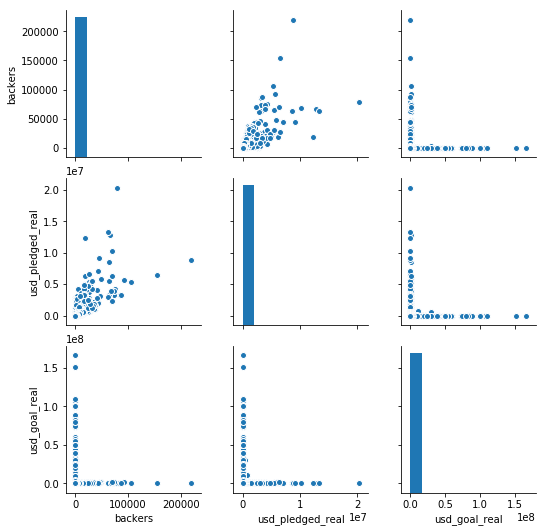

In [15]:
sns.pairplot(base_data[["backers", "usd_pledged_real", "usd_goal_real"]])

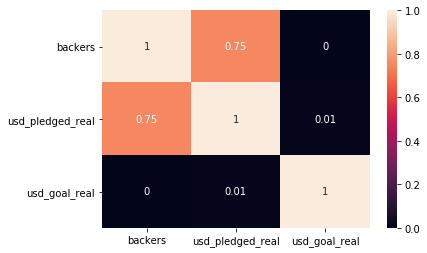

In [16]:
sns.heatmap(base_data[["backers", "usd_pledged_real", "usd_goal_real"]].corr().round(2), annot=True)

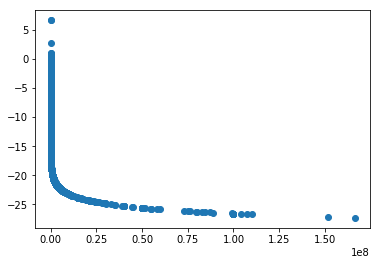

In [17]:
plt.scatter(base_data["usd_goal_real"], np.log(base_data["usd_goal_real"])/np.log(1/2))

In [18]:
"""p = figure(plot_width=400, plot_height=400)
p.circle(x=base_data["backers"], y=base_data["usd_pledged_real"], color=base_data["main_category"])

output_file("scatter.html")

show(p)"""

'p = figure(plot_width=400, plot_height=400)\np.circle(x=base_data["backers"], y=base_data["usd_pledged_real"], color=base_data["main_category"])\n\noutput_file("scatter.html")\n\nshow(p)'

In [16]:
#summary statistics
print("The most successful campaign in dataset:", base_data["usd_pledged_real"].max())
base_data[base_data["usd_pledged_real"] == base_data["usd_pledged_real"].max()]

The most successful campaign in dataset: 20338986.27


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
157270,1799979574,"Pebble Time - Awesome Smartwatch, No Compromises",Product Design,Design,USD,2015-03-28,500000.0,2015-02-24 15:44:42,20338986.27,successful,78471,US,20338986.27,20338986.27,500000.0


In [97]:
perc_success = base_data["usd_pledged_real"].max() * \
100 / base_data[base_data["usd_pledged_real"] == base_data["usd_pledged_real"].max()]["usd_goal_real"].values[0]
print("It exceeded initial goal by {} % percent".format(perc_success.round()))

It exceeded initial goal by 4068.0 % percent


In [100]:
base_data["days_to_deadline"] = (pd.to_datetime(base_data.deadline) - \
                            pd.to_datetime(base_data.launched)).astype("timedelta64[D]").astype("int64")

In [101]:
print("Average pledged money in projects:", base_data["usd_pledged_real"].mean())
print("Average goal in projects:", base_data["usd_goal_real"].mean())
print("Average backers in projects:", base_data["backers"].mean())
print("Average duration of projects:", base_data["days_to_deadline"].mean())

Average pledged money in projects: 9058.924074119337
Average goal in projects: 45454.40146545336
Average backers in projects: 105.61747578969052
Average duration of projects: 33.48112163650336


Percentages of states of campaigns in dataset.
failed        52.215306
successful    35.376234
canceled      10.241086
undefined      0.940683
live           0.739184
suspended      0.487507
Name: state, dtype: float64


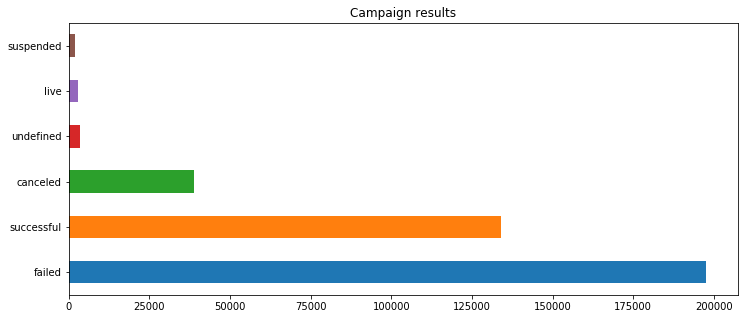

In [102]:
print("Percentages of states of campaigns in dataset.")
print(base_data.state.value_counts()/len(base_data)*100)
base_data.state.value_counts().plot(kind="barh",
                                    figsize=(12, 5),
                                    title="Campaign results")

We need only successful and failed states in data to make classification model, so we should drop everything other.

In [103]:
base_data["avg_per_backer"] = (base_data["usd_pledged_real"]/base_data["backers"]).fillna(0).abs().replace(np.inf, 0)
print("In average backers had pledged {} dollars".format(base_data["avg_per_backer"].mean()))

In average backers had pledged 64.58076593075498 dollars


,Technology,Design,Film & Video,Dance,Theater,Fashion,Food,Music,Art,Photography,Games,Publishing,Comics,Journalism,Crafts
avg_per_backer,95.985817,94.35646,76.1804,70.725558,70.447174,63.856153,62.741457,55.035269,54.870922,52.693231,50.415755,47.763362,41.061157,38.083108,38.019355


Text(0,0.5,'Average pledged per backer (USD)')

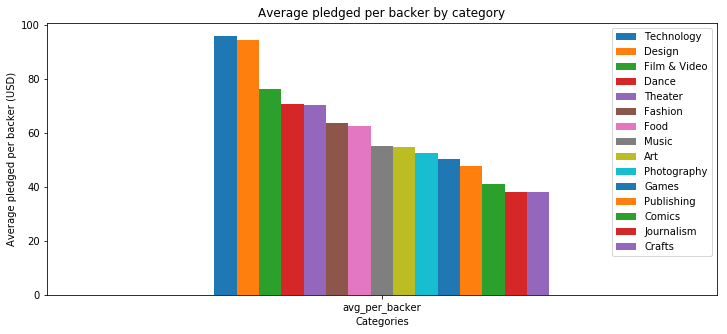

In [211]:
pledge_mapping = dict()
for category in base_data['main_category'].unique():
    cat_df = base_data[base_data['main_category'] == category]
    pledge_mapping.update({category : cat_df['avg_per_backer'].mean()})
pledge_df = pd.DataFrame(pledge_mapping, index=['avg_per_backer'])
pledge_df.sort_values('avg_per_backer', axis=1, inplace=True, ascending=False)
display(pledge_df.head())
_ = pledge_df.plot(kind='bar', 
                    title='Average pledged per backer by category', 
                    rot=0, figsize=(12,5))
plt.xlabel('Categories')
plt.ylabel('Average pledged per backer (USD)')

From bar graph we can see that in average backers mostly pledged in tech (96 USD) and design (94 USD) projects.

In [106]:
data = base_data.drop(["ID", "name", "goal", "pledged", "usd pledged", "avg_per_backer"], axis=1)
data.head()

,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,days_to_deadline
0,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95,58
1,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00,59
2,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,failed,3,US,220.0,45000.00,44
3,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,failed,1,US,1.0,5000.00,29
4,Film & Video,Film & Video,USD,2015-08-29,2015-07-04 08:35:03,canceled,14,US,1283.0,19500.00,55


In [107]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 11 columns):
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
launched            378661 non-null object
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
days_to_deadline    378661 non-null int64
dtypes: float64(2), int64(2), object(7)
memory usage: 31.8+ MB


To make our date(launched, deadline) columns informative, let's subtract launched from deadline to have days to deadline.<br>
After that we can drop datetime columns.

In [108]:
data.drop(["deadline", "launched"], axis=1, inplace=True)

In [112]:
data.nunique()

category               159
main_category           15
currency                14
state                    6
backers               3963
country                 23
usd_pledged_real    106065
usd_goal_real        50339
days_to_deadline        99
dtype: int64

In [113]:
for col in data.select_dtypes(include="object"):
    print("\n", col)
    print(data[col].unique())
    print(data[col].value_counts())
    print("_______________________")


 category
['Poetry' 'Narrative Film' 'Music' 'Film & Video' 'Restaurants' 'Food'
 'Drinks' 'Product Design' 'Documentary' 'Nonfiction' 'Indie Rock'
 'Crafts' 'Games' 'Tabletop Games' 'Design' 'Comic Books' 'Art Books'
 'Fashion' 'Childrenswear' 'Theater' 'Comics' 'DIY' 'Webseries'
 'Animation' 'Food Trucks' 'Public Art' 'Illustration' 'Photography' 'Pop'
 'People' 'Art' 'Family' 'Fiction' 'Accessories' 'Rock' 'Hardware'
 'Software' 'Weaving' 'Gadgets' 'Web' 'Jazz' 'Ready-to-wear' 'Festivals'
 'Video Games' 'Anthologies' 'Publishing' 'Shorts' 'Electronic Music'
 'Radio & Podcasts' 'Apps' 'Cookbooks' 'Apparel' 'Metal' 'Comedy'
 'Hip-Hop' 'Periodicals' 'Dance' 'Technology' 'Painting' 'World Music'
 'Photobooks' 'Drama' 'Architecture' 'Young Adult' 'Latin' 'Mobile Games'
 'Flight' 'Fine Art' 'Action' 'Playing Cards' 'Makerspaces' 'Punk'
 'Thrillers' "Children's Books" 'Audio' 'Performance Art' 'Ceramics'
 'Vegan' 'Graphic Novels' 'Fabrication Tools' 'Performances' 'Sculpture'
 'Sound' 'St

Let's drop category column, because:
- It has 159 unique values(OneHot Encoding will make min. 158 columns)
- to make our models faster
- not to have much noise in data
- more general info is contained in main_category

In [114]:
data.drop("category", axis=1, inplace=True)

In [115]:
data.var() == 0

backers             False
usd_pledged_real    False
usd_goal_real       False
days_to_deadline    False
dtype: bool

In [116]:
data.var()

backers             8.229847e+05
usd_pledged_real    8.276149e+09
usd_goal_real       1.329294e+12
days_to_deadline    4.344019e+03
dtype: float64

In [117]:
data = data[(data["state"] == "successful") | (data["state"] == "failed")]
data.state = np.where(data["state"] == "successful", 1, 0)
data.shape

(331675, 8)

Mean days for success: 31.156469288423065
Mean days for failure: 34.17335208047785


C:\Users\8460p\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\8460p\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


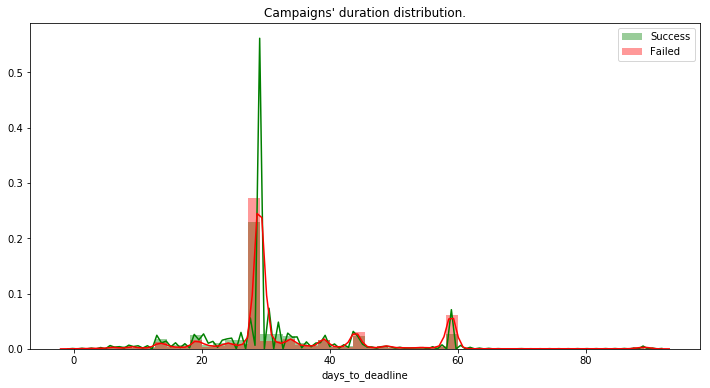

In [118]:
success_avg_dur = data[(data["state"] == 1)]["days_to_deadline"].mean()
failure_avg_dur = data[data["state"] == 0]["days_to_deadline"].mean()
print("Mean days for success: {}".format(success_avg_dur))
print("Mean days for failure: {}".format(failure_avg_dur))
plt.figure(figsize=(12, 6))
plt.title("Campaigns' duration distribution.")
sns.distplot(data[(data["state"] == 1)]["days_to_deadline"], color="green", hist=True, label="Success")
sns.distplot(data[(data["state"] == 0)]["days_to_deadline"], color="red", hist=True, label="Failed")
plt.legend()

In [119]:
data = pd.get_dummies(data, drop_first=True)
data.shape

(331675, 54)

In [120]:
data.columns = [i.replace(",", "").replace('"', "").replace(" & ", "_") for i in data.columns]

In [121]:
data.columns

Index(['state', 'backers', 'usd_pledged_real', 'usd_goal_real',
       'days_to_deadline', 'main_category_Comics', 'main_category_Crafts',
       'main_category_Dance', 'main_category_Design', 'main_category_Fashion',
       'main_category_Film_Video', 'main_category_Food', 'main_category_Games',
       'main_category_Journalism', 'main_category_Music',
       'main_category_Photography', 'main_category_Publishing',
       'main_category_Technology', 'main_category_Theater', 'currency_CAD',
       'currency_CHF', 'currency_DKK', 'currency_EUR', 'currency_GBP',
       'currency_HKD', 'currency_JPY', 'currency_MXN', 'currency_NOK',
       'currency_NZD', 'currency_SEK', 'currency_SGD', 'currency_USD',
       'country_AU', 'country_BE', 'country_CA', 'country_CH', 'country_DE',
       'country_DK', 'country_ES', 'country_FR', 'country_GB', 'country_HK',
       'country_IE', 'country_IT', 'country_JP', 'country_LU', 'country_MX',
       'country_N0', 'country_NL', 'country_NO', 'country_NZ

0    59.612271
1    40.387729
Name: state, dtype: float64


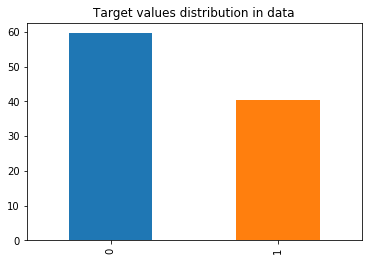

In [122]:
benchmark = data.state.value_counts() / len(data) * 100
print(benchmark)
_ = benchmark.plot(kind="bar", title="Target values distribution in data")
plt.show()

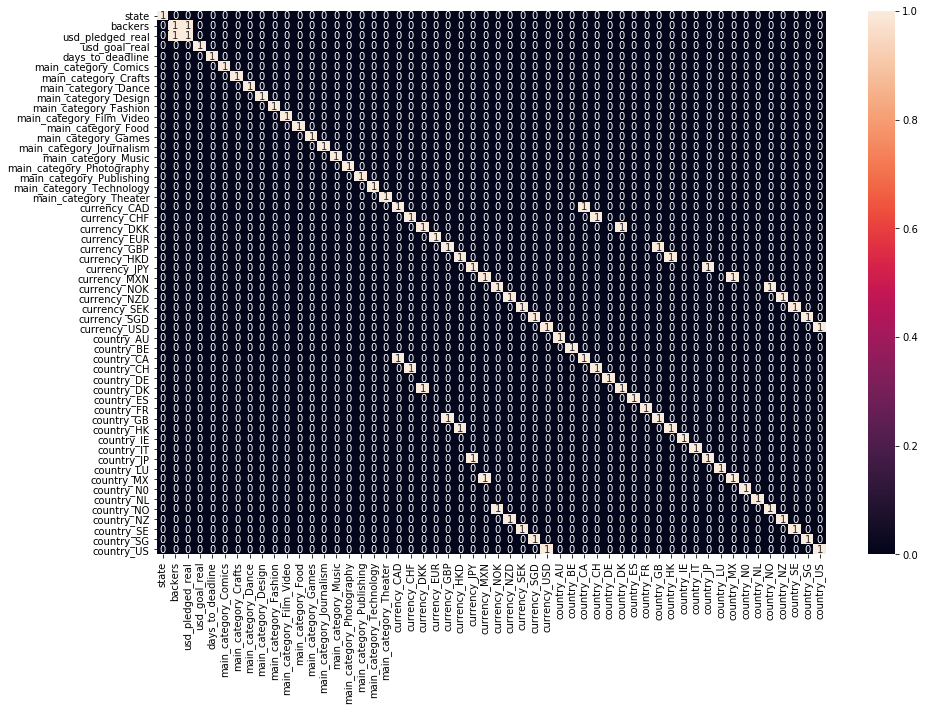

In [78]:
plt.figure(figsize=(15,10))
sns.heatmap((data.corr()>=0.75).abs().round(2), annot=True)

There is correlation between currencies and countries, this was also assumed from barplots above.

In [123]:
currencies = [i for i in data.columns if "currency" in i] 
data.drop(currencies, axis=1, inplace=True)

In [138]:
sample_data = data.sample(n=10**5*3, random_state=42)
final_test_data = data.drop(sample_data.index, axis=0)
print("Sample data")
print(sample_data.state.value_counts()/len(sample_data))
print("Final test data")
print(final_test_data.state.value_counts()/len(final_test_data))
sample_data.head()

Sample data
0    0.59633
1    0.40367
Name: state, dtype: float64
Final test data
0    0.594159
1    0.405841
Name: state, dtype: float64


,state,backers,usd_pledged_real,usd_goal_real,days_to_deadline,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,...,country_JP,country_LU,country_MX,country_N0,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
271115,0,21,1007.5,25000.0,29,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
204452,0,1,25.0,10000.0,29,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
120052,1,50,6701.0,5000.0,20,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
247629,0,5,155.0,500.0,58,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
332022,0,8,406.0,3000.0,34,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [139]:
sample_data.nunique()

state                            2
backers                       3760
usd_pledged_real             91157
usd_goal_real                41789
days_to_deadline                92
main_category_Comics             2
main_category_Crafts             2
main_category_Dance              2
main_category_Design             2
main_category_Fashion            2
main_category_Film_Video         2
main_category_Food               2
main_category_Games              2
main_category_Journalism         2
main_category_Music              2
main_category_Photography        2
main_category_Publishing         2
main_category_Technology         2
main_category_Theater            2
country_AU                       2
country_BE                       2
country_CA                       2
country_CH                       2
country_DE                       2
country_DK                       2
country_ES                       2
country_FR                       2
country_GB                       2
country_HK          

In [140]:
final_test_data.nunique()

state                            2
backers                       1342
usd_pledged_real             15044
usd_goal_real                 7385
days_to_deadline                92
main_category_Comics             2
main_category_Crafts             2
main_category_Dance              2
main_category_Design             2
main_category_Fashion            2
main_category_Film_Video         2
main_category_Food               2
main_category_Games              2
main_category_Journalism         2
main_category_Music              2
main_category_Photography        2
main_category_Publishing         2
main_category_Technology         2
main_category_Theater            2
country_AU                       2
country_BE                       2
country_CA                       2
country_CH                       2
country_DE                       2
country_DK                       2
country_ES                       2
country_FR                       2
country_GB                       2
country_HK          

In [239]:
X = sample_data.drop(["state", "usd_pledged_real"], axis=1)

Y_classification = sample_data.state

#regression
Y_regression = sample_data.usd_pledged_real

#classification
x_train, x_test, y_train, y_test = train_test_split(X, Y_classification, test_size=0.25, random_state=42)

In order to have faster computations we have to try to sample or implement dimension reduction techniques.

## Classification

In [240]:
formula = "state~" + "+".join(X.columns)
formula

'state~backers+usd_goal_real+days_to_deadline+main_category_Comics+main_category_Crafts+main_category_Dance+main_category_Design+main_category_Fashion+main_category_Film_Video+main_category_Food+main_category_Games+main_category_Journalism+main_category_Music+main_category_Photography+main_category_Publishing+main_category_Technology+main_category_Theater+country_AU+country_BE+country_CA+country_CH+country_DE+country_DK+country_ES+country_FR+country_GB+country_HK+country_IE+country_IT+country_JP+country_LU+country_MX+country_N0+country_NL+country_NO+country_NZ+country_SE+country_SG+country_US'

In [248]:
#statsmodels logit
logit = Logit.from_formula(formula=formula, data=X.join(Y_classification)).fit()

Optimization terminated successfully.
         Current function value: 0.317866
         Iterations 13


In [249]:
logit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
===========================================================================
Model:                 Logit               Pseudo R-squared:    0.529      
Dependent Variable:    state               AIC:                 190799.5874
Date:                  2018-12-10 20:49    BIC:                 191224.0489
No. Observations:      300000              Log-Likelihood:      -95360.    
Df Model:              39                  LL-Null:             -2.0234e+05
Df Residuals:          299960              LLR p-value:         0.0000     
Converged:             1.0000              Scale:               1.0000     
No. Iterations:        13.0000                                             
---------------------------------------------------------------------------
                           Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
Intercept                 -0.4889   0.1828   -2.6743 0.0075 -0.8472 -0.1306
backers                    0.0549   0.0003  219.5880 0.0000  0.0545  0.0554
usd_goal_real             -0.0002   0.0000 -171.1031 0.0000 -0.0002 -0.0002
days_to_deadline          -0.0126   0.0004  -28.0617 0.0000 -0.0135 -0.0117
main_category_Comics      -0.5086   0.0378  -13.4449 0.0000 -0.5828 -0.4345
main_category_Crafts      -0.6727   0.0382  -17.5904 0.0000 -0.7477 -0.5978
main_category_Dance        0.7156   0.0499   14.3292 0.0000  0.6177  0.8134
main_category_Design      -0.6549   0.0306  -21.4378 0.0000 -0.7148 -0.5951
main_category_Fashion     -0.5962   0.0296  -20.1636 0.0000 -0.6541 -0.5382
main_category_Film_Video   0.2223   0.0216   10.2956 0.0000  0.1799  0.2646
main_category_Food        -0.4784   0.0305  -15.6768 0.0000 -0.5382 -0.4186
main_category_Games       -1.5305   0.0325  -47.1414 0.0000 -1.5941 -1.4668
main_category_Journalism  -0.6809   0.0561  -12.1453 0.0000 -0.7907 -0.5710
main_category_Music        0.1410   0.0220    6.4162 0.0000  0.0979  0.1841
main_category_Photography -0.3852   0.0348  -11.0748 0.0000 -0.4534 -0.3171
main_category_Publishing  -0.5292   0.0243  -21.7971 0.0000 -0.5768 -0.4817
main_category_Technology  -0.6018   0.0335  -17.9455 0.0000 -0.6676 -0.5361
main_category_Theater      0.7152   0.0332   21.5545 0.0000  0.6502  0.7802
country_AU                -0.0759   0.1867   -0.4064 0.6845 -0.4418  0.2901
country_BE                 0.2339   0.2357    0.9921 0.3211 -0.2281  0.6959
country_CA                 0.0480   0.1841    0.2609 0.7942 -0.3128  0.4088
country_CH                 0.8346   0.2343    3.5614 0.0004  0.3753  1.2939
country_DE                -0.0272   0.1929   -0.1409 0.8879 -0.4052  0.3508
country_DK                 0.3649   0.2086    1.7493 0.0802 -0.0439  0.7738
country_ES                -0.1829   0.2027   -0.9022 0.3669 -0.5802  0.2144
country_FR                 0.3513   0.1950    1.8017 0.0716 -0.0309  0.7335
country_GB                 0.2491   0.1825    1.3651 0.1722 -0.1085  0.6067
country_HK                 1.0007   0.2408    4.1565 0.0000  0.5289  1.4726
country_IE                -0.2978   0.2319   -1.2838 0.1992 -0.7524  0.1568
country_IT                -0.1421   0.2012   -0.7065 0.4799 -0.5364  0.2522
country_JP                 0.1835   0.7134    0.2572 0.7970 -1.2147  1.5817
country_LU                 0.4196   0.5126    0.8185 0.4131 -0.5851  1.4243
country_MX                -0.2887   0.1995   -1.4470 0.1479 -0.6797  0.1023
country_N0                 1.9304   0.2381    8.1075 0.0000  1.4637  2.3971
country_NL                 0.1016   0.1969    0.5158 0.6060 -0.2844  0.4875
country_NO                 0.0020   0.2320    0.0086 0.9931 -0.4527  0.4567
country_NZ                 0.0613   0.2039    0.3008 0.7636 -0.3383  0.4610
country_SE                -0.0904   0.2025   -0.4462 0.6555 -0.4873  0.3066
country_SG                -0.0581   0.2437   -0.2385 0.8115 -0.5359  0.4196
country_US                 0.2

In [228]:
significants = model_ols.pvalues[model_ols.pvalues < 0.05].index.tolist()

In [234]:
logit.get_margeff().summary()
#RuntimeWarning: overflow encountered

C:\Users\8460p\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1698: RuntimeWarning: overflow encountered in square
  return np.exp(-X)/(1+np.exp(-X))**2
C:\Users\8460p\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1698: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(-X)/(1+np.exp(-X))**2
C:\Users\8460p\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1698: RuntimeWarning: overflow encountered in exp
  return np.exp(-X)/(1+np.exp(-X))**2
C:\Users\8460p\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1698: RuntimeWarning: invalid value encountered in square
  return np.exp(-X)/(1+np.exp(-X))**2
C:\Users\8460p\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\8460p\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encoun

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                  state
Method:                          dydx
At:                           overall
=============================================================================================
                               dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
backers                          nan        nan        nan        nan         nan         nan
usd_goal_real                    nan        nan        nan        nan         nan         nan
days_to_deadline                 nan        nan        nan        nan         nan         nan
main_category_Comics             nan        nan        nan        nan         nan         nan
main_category_Crafts             nan        nan        nan        nan         nan         nan
main_category_Dance              nan        nan        nan        nan         nan         nan
main_category_Design             nan        nan        nan        nan         nan         nan
main_category_Fashion            nan        nan        nan        nan         nan         nan
main_category_Film_Video         nan        nan        nan        nan         nan         nan
main_category_Food               nan        nan        nan        nan         nan         nan
main_category_Games              nan        nan        nan        nan         nan         nan
main_category_Journalism         nan        nan        nan        nan         nan         nan
main_category_Music              nan        nan        nan        nan         nan         nan
main_category_Photography        nan        nan        nan        nan         nan         nan
main_category_Publishing         nan        nan        nan        nan         nan         nan
main_category_Technology         nan        nan        nan        nan         nan         nan
main_category_Theater            nan        nan        nan        nan         nan         nan
country_AU                       nan        nan        nan        nan         nan         nan
country_BE                       nan        nan        nan        nan         nan         nan
country_CA                       nan        nan        nan        nan         nan         nan
country_CH                       nan        nan        nan        nan         nan         nan
country_DE                       nan        nan        nan        nan         nan         nan
country_DK                       nan        nan        nan        nan         nan         nan
country_ES                       nan        nan        nan        nan         nan         nan
country_FR                       nan        nan        nan        nan         nan         nan
country_GB                       nan        nan        nan        nan         nan         nan
country_HK                       nan        nan        nan        nan         nan         nan
country_IE                       nan        nan        nan        nan         nan         nan
country_IT                       nan        nan        nan        nan         nan         nan
country_JP                       nan        nan        nan        nan         nan         nan
country_LU                       nan        nan        nan        nan         nan         nan
country_MX                       nan        nan        nan        nan         nan         nan
country_N0                       nan        nan        nan        nan         nan         nan
country_NL                       nan        nan        nan        nan         nan         nan
country_NO                       nan        nan        nan        nan         nan         nan
country_NZ                       nan        nan        nan        nan         nan         nan
country_SE                       nan        nan        nan        nan         nan         nan
co

In [130]:
logreg = LogisticRegression(random_state=42)

params_logreg = {
    "C": np.linspace(0.000001, 1, 50),
    "penalty": ['l1', 'l2'],
    "class_weight": ['balanced', None],
}

gs_logreg = GridSearchCV(logreg, param_grid=params_logreg, scoring="roc_auc", cv=5, n_jobs=-1)

tree = DecisionTreeClassifier(random_state=42)

params_tree = {
    "max_depth": range(5,16),
    "min_samples_leaf": range(150, 251, 10),
    "class_weight": ['balanced', None],
    "criterion": ['gini', 'entropy']
}

gs_tree = GridSearchCV(tree, param_grid=params_tree, scoring="roc_auc", cv=5, n_jobs=-1)

In [131]:
%timeit gs_logreg.fit(X, Y_classification) # sample_size=10**3

6.5 s ± 197 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [132]:
gs_logreg.fit(X, Y_classification)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([1.00000e-06, 2.04091e-02, 4.08173e-02, 6.12254e-02, 8.16336e-02,
       1.02042e-01, 1.22450e-01, 1.42858e-01, 1.63266e-01, 1.83674e-01,
       2.04082e-01, 2.24491e-01, 2.44899e-01, 2.65307e-01, 2.85715e-01,
       3.06123e-01, 3.26531e-01, 3.46939e-01, 3.67348e-01, 3.87756e....59184e-01, 9.79592e-01, 1.00000e+00]), 'penalty': ['l1', 'l2'], 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [133]:
gs_logreg.best_params_

{'C': 0.4489801428571428, 'class_weight': 'balanced', 'penalty': 'l1'}

In [134]:
gs_logreg.best_score_ * 100

95.9587759219867

In [135]:
gs_tree.fit(X, Y_classification)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(5, 16), 'min_samples_leaf': range(150, 251, 10), 'class_weight': ['balanced', None], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [136]:
gs_tree.best_params_

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 170}

In [137]:
gs_tree.best_score_

0.9091606074257977

### Logistic Regression

In [250]:
logreg = LogisticRegression(random_state=42, C=0.4489801428571428, class_weight="balanced", penalty="l1")
logreg.fit(x_train, y_train)
y_pred_logreg = logreg.predict(x_test)

### Decision Tree

In [146]:
tree = DecisionTreeClassifier(random_state=42, class_weight=None, criterion="gini", max_depth=5, min_samples_leaf=170)
tree.fit(x_train, y_train)
y_pred_tree = tree.predict(x_test)

In [147]:
rand_forest = RandomForestClassifier(random_state=42, max_depth=5, min_samples_leaf=170, n_estimators=300)

grad_boost = GradientBoostingClassifier(random_state=42, max_depth=5, min_samples_leaf=170, n_estimators=300)

In [148]:
rand_forest.fit(x_train, y_train)
y_pred_forest = rand_forest.predict(x_test)

grad_boost.fit(x_train, y_train)
y_pred_grad = grad_boost.predict(x_test)

In [149]:
"""grid = {
    'C': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0],
    'penalty': ['l2'],
    'n_jobs': [-1]
}
paramGrid = ParameterGrid(grid)
bestModel, bestScore, allModels, allScores = 
pf.bestFit(LogisticRegression, paramGrid,
           X_train, y_train, X_val, y_val, 
           metric = roc_auc_score, bestScore='max',
           scoreLabel = "AUC")
print(bestModel, bestScore)"""

'grid = {\n    \'C\': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0],\n    \'penalty\': [\'l2\'],\n    \'n_jobs\': [-1]\n}\nparamGrid = ParameterGrid(grid)\nbestModel, bestScore, allModels, allScores = \npf.bestFit(LogisticRegression, paramGrid,\n           X_train, y_train, X_val, y_val, \n           metric = roc_auc_score, bestScore=\'max\',\n           scoreLabel = "AUC")\nprint(bestModel, bestScore)'

In [150]:
#decision tree feature importances
pd.DataFrame(data=tree.feature_importances_, 
             index=X.columns, 
             columns=['importances']).sort_values(by="importances", ascending=False).head()

,importances
backers,0.829313
usd_goal_real,0.170687
country_SG,0.000000
country_SE,0.000000
country_DE,0.000000


In [254]:
#random forest feature importances
pd.DataFrame(data=rand_forest.feature_importances_, 
             index=X.columns, 
             columns=['importances']).sort_values(by="importances", ascending=False).head(10)

,importances
backers,0.674560
usd_goal_real,0.141261
days_to_deadline,0.059858
main_category_Technology,0.030765
main_category_Music,0.023176
main_category_Theater,0.018060
main_category_Food,0.010340
main_category_Fashion,0.010002
main_category_Comics,0.009840
main_category_Dance,0.005141


In [256]:
#gradient boosting feature importances
pd.DataFrame(data=grad_boost.feature_importances_, 
             index=X.columns, 
             columns=['importances']).sort_values(by="importances", ascending=False).head(10)

,importances
backers,0.423970
usd_goal_real,0.282511
days_to_deadline,0.085592
main_category_Design,0.024221
country_US,0.021124
main_category_Games,0.020527
main_category_Film_Video,0.013941
main_category_Music,0.012863
main_category_Comics,0.012448
main_category_Technology,0.010196


## Evaluation

In [151]:
models = {"Logistic Regression": logreg, "Decision Tree": tree, "Random Forest": rand_forest, "Gradient Boosting": grad_boost}

scores = {"ROC_AUC": roc_auc_score, "Accuracy": accuracy_score, "Recall": recall_score}


 Logistic Regression 

Train score: 0.7521244444444445
Test score: 0.75292


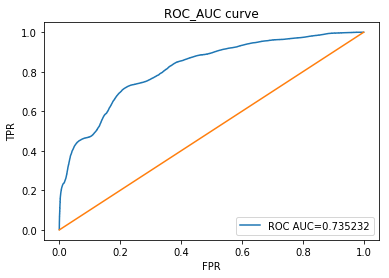

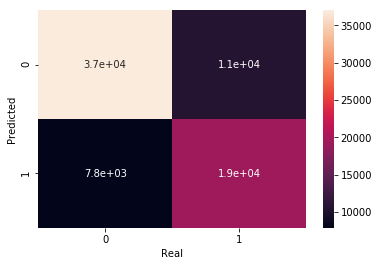

             precision    recall  f1-score   support

          0       0.78      0.83      0.80     44880
          1       0.71      0.65      0.68     30120

avg / total       0.75      0.75      0.75     75000

ROC_AUC 0.7352316669152267
Accuracy 0.75292
Recall 0.6453519256308101

 Decision Tree 

Train score: 0.9216355555555555
Test score: 0.9200133333333333


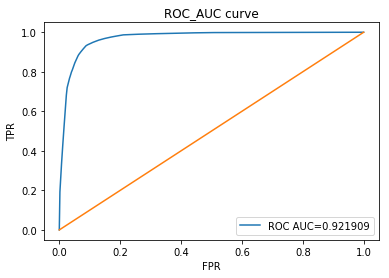

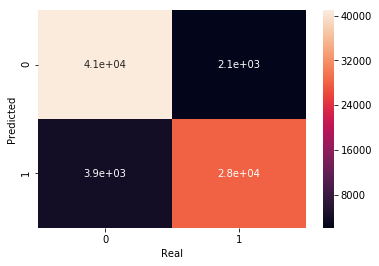

             precision    recall  f1-score   support

          0       0.95      0.91      0.93     44880
          1       0.88      0.93      0.90     30120

avg / total       0.92      0.92      0.92     75000

ROC_AUC 0.9219088441243938
Accuracy 0.9200133333333333
Recall 0.9315405046480744

 Random Forest 

Train score: 0.8948177777777778
Test score: 0.8944933333333334


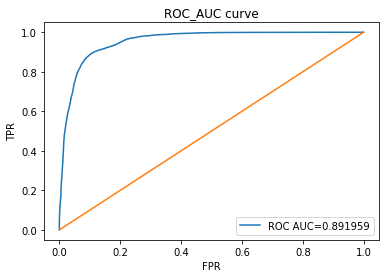

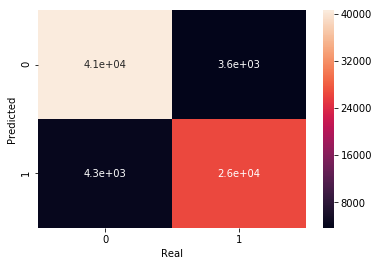

             precision    recall  f1-score   support

          0       0.92      0.90      0.91     44880
          1       0.86      0.88      0.87     30120

avg / total       0.89      0.89      0.89     75000

ROC_AUC 0.8919593906015866
Accuracy 0.8944933333333334
Recall 0.8790836653386455

 Gradient Boosting 

Train score: 0.9357955555555556
Test score: 0.9336533333333333


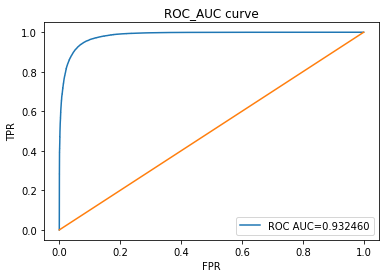

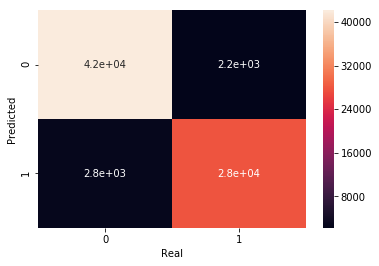

             precision    recall  f1-score   support

          0       0.95      0.94      0.94     44880
          1       0.91      0.93      0.92     30120

avg / total       0.93      0.93      0.93     75000

ROC_AUC 0.9324596888737385
Accuracy 0.9336533333333333
Recall 0.926394422310757


In [152]:

for model_name, model in models.items():
    print("\n", model_name, "\n")
    print("Train score:", model.score(x_train, y_train))
    print("Test score:", model.score(x_test, y_test))
    pred = model.predict(x_test)
    FPR,TPR,tresholds=roc_curve(y_test,model.predict_proba(x_test)[:,1])
    #plt.subplot(121)
    plt.title("ROC_AUC curve")
    plt.plot(FPR,TPR,label="ROC AUC=%f"%roc_auc_score(y_test,pred))
    plt.plot([0,1],[0,1])
    plt.legend(loc="lower right")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()
    #plt.subplot(122)
    #plt.figure(figsize=(8, 4))
    sns.heatmap(confusion_matrix(y_test, pred).T, annot=True)
    plt.xlabel("Real")
    plt.ylabel("Predicted")
    plt.show()
    print(classification_report(y_test, pred))
    for score_name, score in scores.items():
        print(score_name, score(y_test, pred))

Our models predict Failure of campaigns better than their success...


## Neural Networks

In [212]:
n_cols = X.shape[1]
target = to_categorical(Y_classification)
early_stopping_monitor = EarlyStopping(patience=3)

#### Rectified Linear Activation
$$
RELU(x) = \begin{cases} 0, & \mbox{if } x\mbox{ < 0} \\ x, & \mbox{if } x \geq 0 \end{cases}
$$

In [157]:
net = Sequential()

net.add(Dense(100, activation="relu", input_shape=(n_cols,)))
net.add(Dense(100, activation="relu", input_shape=(n_cols,)))
net.add(Dense(50, activation="relu", input_shape=(n_cols,)))
net.add(Dense(1, activation="sigmoid"))

net.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

net.fit(X, Y_classification, validation_split=0.25, epochs=10, callbacks=[early_stopping_monitor])

Train on 225000 samples, validate on 75000 samples
Epoch 1/10
225000/225000 [==============================] - 12s 52us/step - loss: 8.9345 - acc: 0.4395 - val_loss: 9.5078 - val_acc: 0.4036
Epoch 2/10
225000/225000 [==============================] - 12s 52us/step - loss: 9.5066 - acc: 0.4037 - val_loss: 9.5077 - val_acc: 0.4036
Epoch 3/10
225000/225000 [==============================] - 12s 55us/step - loss: 8.5791 - acc: 0.4617 - val_loss: 1.2809 - val_acc: 0.9161
Epoch 4/10
225000/225000 [==============================] - 13s 57us/step - loss: 1.7716 - acc: 0.8747 - val_loss: 0.2643 - val_acc: 0.9182
Epoch 5/10
225000/225000 [==============================] - 14s 61us/step - loss: 0.2565 - acc: 0.9147 - val_loss: 0.2110 - val_acc: 0.9219
Epoch 6/10
225000/225000 [==============================] - 13s 58us/step - loss: 0.2348 - acc: 0.9187 - val_loss: 0.2235 - val_acc: 0.9180
Epoch 7/10
225000/225000 [==============================] - 14s 61us/step - loss: 0.2077 - acc: 0.9231 - val_

In [236]:
net.save("crowd_neural_net.h5")

## Linear Regression

In [158]:
X.shape

(300000, 39)

In [163]:
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(X, Y_regression, random_state=42, test_size=0.25)

In [164]:
lm = LinearRegression()

cv_scores = cross_val_score(lm, X, Y_regression, cv=5, n_jobs=-1)

pd.Series(cv_scores, name="LM Scores")

0    0.600130
1    0.498681
2    0.570552
3    0.574151
4    0.555627
Name: LM Scores, dtype: float64

In [165]:
pd.Series(cv_scores, name="LM Scores").describe()

count    5.000000
mean     0.559828
std      0.037752
min      0.498681
25%      0.555627
50%      0.570552
75%      0.574151
max      0.600130
Name: LM Scores, dtype: float64

In [166]:
lm.fit(x_train_reg, y_train_reg)
y_pred_reg = lm.predict(x_test_reg)

In [167]:
print("R2:", lm.score(x_test_reg, y_test_reg))

R2: 0.5630646419739408


In [169]:
pd.DataFrame(data=lm.coef_, index=X.columns)

,0
backers,75.273159
usd_goal_real,0.000114
days_to_deadline,56.200500
main_category_Comics,-3942.325322
main_category_Crafts,-517.305974
main_category_Dance,70.788553
main_category_Design,6515.621339
main_category_Fashion,1169.975877
main_category_Film_Video,1064.833237
main_category_Food,867.538946


In [170]:
#statsmodels OLS
formula = Y_regression.name + "~" + "+".join(X.columns)
formula

'usd_pledged_real~backers+usd_goal_real+days_to_deadline+main_category_Comics+main_category_Crafts+main_category_Dance+main_category_Design+main_category_Fashion+main_category_Film_Video+main_category_Food+main_category_Games+main_category_Journalism+main_category_Music+main_category_Photography+main_category_Publishing+main_category_Technology+main_category_Theater+country_AU+country_BE+country_CA+country_CH+country_DE+country_DK+country_ES+country_FR+country_GB+country_HK+country_IE+country_IT+country_JP+country_LU+country_MX+country_N0+country_NL+country_NO+country_NZ+country_SE+country_SG+country_US'

In [171]:
model_ols = ols(formula=formula, data=X.join(Y_regression)).fit()
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       usd_pledged_real   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                 1.020e+04
Date:                Mon, 10 Dec 2018   Prob (F-statistic):               0.00
Time:                        16:25:49   Log-Likelihood:            -3.7443e+06
No. Observations:              300000   AIC:                         7.489e+06
Df Residuals:                  299960   BIC:                         7.489e+06
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  3450.7312   3111.451      1.109      0.267   -2647.626    9549.088
backers                      81.6410      0.131    625.567      0.000      81.385      81.897
usd_goal_real                 0.0001      0.000      1.218      0.223    -7.6e-05       0.000
days_to_deadline             55.0240      9.212      5.973      0.000      36.968      73.080
main_category_Comics      -4485.7399    794.089     -5.649      0.000   -6042.132   -2929.348
main_category_Crafts       -335.8376    867.037     -0.387      0.699   -2035.207    1363.531
main_category_Dance         120.2061   1197.062      0.100      0.920   -2226.003    2466.415
main_category_Design       5632.5627    595.369      9.461      0.000    4465.656    6799.470
main_category_Fashion       977.1784    634.282      1.541      0.123    -265.996    2220.353
main_category_Film_Video    866.7836    504.864      1.717      0.086    -122.735    1856.302
main_category_Food          901.5585    615.431      1.465      0.143    -304.668    2107.785
main_category_Games       -5728.9686    578.939     -9.896      0.000   -6863.672   -4594.265
main_category_Journalism   -389.2036   1121.498     -0.347      0.729   -2587.309    1808.901
main_category_Music        -594.3466    523.490     -1.135      0.256   -1620.373     431.680
main_category_Photography   588.2919    798.961      0.736      0.462    -977.650    2154.233
main_category_Publishing  -1155.1167    549.173     -2.103      0.035   -2231.479     -78.754
main_category_Technology   9089.8603    586.786     15.491      0.000    7939.776    1.02e+04
main_category_Theater       317.5430    783.302      0.405      0.685   -1217.706    1852.792
country_AU                -7532.4593   3177.949     -2.370      0.018   -1.38e+04   -1303.769
country_BE                -3459.4757   4247.638     -0.814      0.415   -1.18e+04    4865.775
country_CA                -7326.2943   3128.170     -2.342      0.019   -1.35e+04   -1195.169
country_CH                 2387.4095   4030.693      0.592      0.554   -5512.635    1.03e+04
country_DE                -5483.4882   3278.479     -1.673      0.094   -1.19e+04     942.239
country_DK                -6275.1678   3755.686     -1.671      0.095   -1.36e+04    1085.871
country_ES                -6756.2285   3436.773     -1.966      0.049   -1.35e+04     -20.251
country_FR                -4658.3805   3347.246     -1.392      0.164   -1.12e+04    1902.127
country_GB                -5601.2224   3094.839     -1.810      0.070   -1.17e+04     464.575
country_HK                -2338.1355   4337.373     -0.539      0.590   -1.08e+04    6162.993
country_IE                -5991.5589   4004.442     -1.496      0.135   -1.38e+04    1857.036
country_IT                -6177.1897   3366.893     -1.835      0.067   -1.

In [190]:
model_ols.pvalues < 0.05

Intercept                    False
backers                       True
usd_goal_real                False
days_to_deadline              True
main_category_Comics          True
main_category_Crafts         False
main_category_Dance          False
main_category_Design          True
main_category_Fashion        False
main_category_Film_Video     False
main_category_Food           False
main_category_Games           True
main_category_Journalism     False
main_category_Music          False
main_category_Photography    False
main_category_Publishing      True
main_category_Technology      True
main_category_Theater        False
country_AU                    True
country_BE                   False
country_CA                    True
country_CH                   False
country_DE                   False
country_DK                   False
country_ES                    True
country_FR                   False
country_GB                   False
country_HK                   False
country_IE          

In [173]:
residuals = model_ols.resid
pred_values = model_ols.predict()
true_values = Y_regression
actual_resid = true_values - pred_values

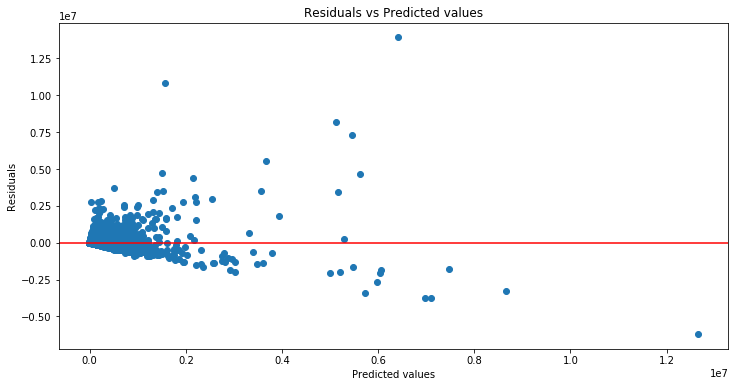

In [174]:
plt.figure(figsize=(12, 6))
plt.scatter(pred_values, residuals)
plt.axhline(y=0, c="red")
plt.title("Residuals vs Predicted values")
plt.ylabel("Residuals")
plt.xlabel("Predicted values")
plt.show()

(array([1.00000e+00, 5.00000e+00, 6.15000e+02, 2.99343e+05, 2.80000e+01,
        4.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([-6189167.51517155, -4177553.23437143, -2165938.95357131,
         -154324.67277118,  1857289.60802894,  3868903.88882906,
         5880518.16962919,  7892132.45042931,  9903746.73122944,
        11915361.01202956, 13926975.29282968]),
 <a list of 10 Patch objects>)

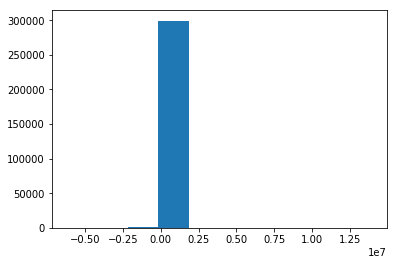

In [177]:
plt.hist(residuals)

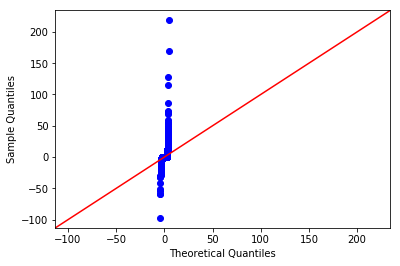

In [180]:
#QQ plot
qqplot(residuals,fit=True, line='45')
plt.show()

In [181]:
#Shapiro-Wilk normality test. 
#The null-hypothesis of this test is that the data was drawn from a normal distribution
#We reject the Null hypothesis which means that we can state with 95% confidence that our data is not normal
stat, p = shapiro(residuals)
print("Stat:", stat,"P:", p)

Stat: 0.06466072797775269 P: 0.0


C:\Users\8460p\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [237]:
#Rainbow test for linearity
#The Null hypothesis is that the regression is correctly modelled as linear
#p-value is more than 0.05, which means that we fail to reject the null hypothesis
linear_rainbow(model_ols)

(0.47541392471525484, 0.9999999999999999)

Model is linear

# Final testing

In [186]:
final_test_data.head()

,state,backers,usd_pledged_real,usd_goal_real,days_to_deadline,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,...,country_JP,country_LU,country_MX,country_N0,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
6,1,16,1205.00,1000.0,19,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
18,1,7,250.00,250.0,14,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
21,0,1,0.81,2026.1,29,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
39,1,277,17499.99,15000.0,29,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
41,1,34,2100.00,2100.0,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [189]:
x_final = final_test_data.drop(["state", "usd_pledged_real"], axis=1)
y_final_class = final_test_data.state
y_final_regr = final_test_data.usd_pledged_real


 Logistic Regression 

Final score: 0.754759273875296


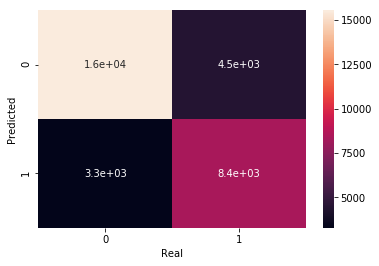

             precision    recall  f1-score   support

          0       0.78      0.83      0.80     18820
          1       0.72      0.65      0.68     12855

avg / total       0.75      0.75      0.75     31675

ROC_AUC 0.7383825291580951
Accuracy 0.754759273875296
Recall 0.6514196810579541

 Decision Tree 

Final score: 0.9217995264404104


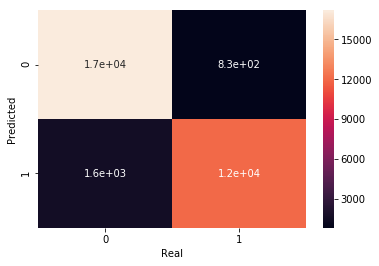

             precision    recall  f1-score   support

          0       0.95      0.91      0.93     18820
          1       0.88      0.94      0.91     12855

avg / total       0.92      0.92      0.92     31675

ROC_AUC 0.9239108882652953
Accuracy 0.9217995264404104
Recall 0.93512252042007

 Random Forest 

Final score: 0.8959116022099447


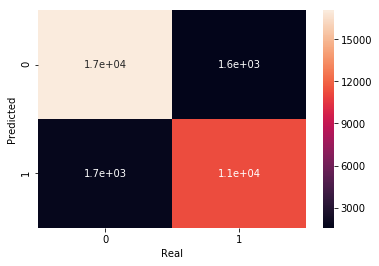

             precision    recall  f1-score   support

          0       0.92      0.91      0.91     18820
          1       0.87      0.88      0.87     12855

avg / total       0.90      0.90      0.90     31675

ROC_AUC 0.8932618005704931
Accuracy 0.8959116022099447
Recall 0.8791909762738234

 Gradient Boosting 

Final score: 0.9345224940805051


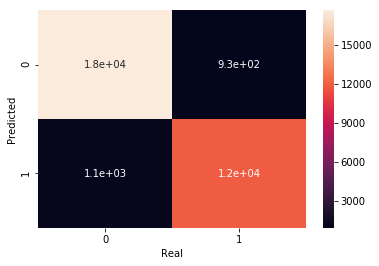

             precision    recall  f1-score   support

          0       0.95      0.94      0.94     18820
          1       0.91      0.93      0.92     12855

avg / total       0.93      0.93      0.93     31675

ROC_AUC 0.9334341058259975
Accuracy 0.9345224940805051
Recall 0.9276546091015169


In [193]:
for model_name, model in models.items():
    print("\n", model_name, "\n")
    print("Final score:", model.score(x_final, y_final_class))
    pred = model.predict(x_final)
    sns.heatmap(confusion_matrix(y_final_class, pred).T, annot=True)
    plt.xlabel("Real")
    plt.ylabel("Predicted")
    plt.show()
    print(classification_report(y_final_class, pred))
    for score_name, score in scores.items():
        print(score_name, score(y_final_class, pred))

In [204]:
cf = confusion_matrix(y_final_class, np.where(net.predict_proba(x_final) > 0.5, 1, 0))

Text(33,0.5,'Predicted')

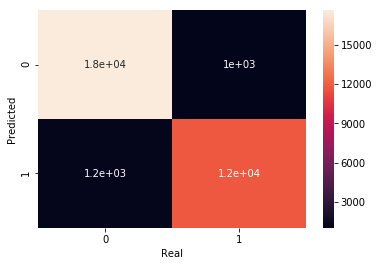

In [205]:
sns.heatmap(cf.T, annot=True)
plt.xlabel("Real")
plt.ylabel("Predicted")

In [208]:
r2_score(y_final_regr, model_ols.predict(x_final))

0.4949726850519497

In [215]:
models = {"Logistic Regression": logreg, "Decision Tree": tree, "Random Forest": rand_forest, "Gradient Boosting": grad_boost}

scores = {"ROC_AUC": roc_auc_score, "Accuracy": accuracy_score, "Recall": recall_score}

In [258]:
report = pd.DataFrame()
for model_name, model in models.items():
    pred = model.predict(x_test)
    score_list = [score(y_test, pred) for score in scores.values()]
    score_list.append(model.score(x_train, y_train))
    score_list.append(model.score(x_test, y_test))
    report[model_name] = score_list
index = [score_name for score_name in scores.keys()]
index.append("Train")
index.append("Test")
report.index = index
report = report.round(2) * 100
report

,Logistic Regression,Decision Tree,Random Forest,Gradient Boosting
ROC_AUC,74.0,92.0,89.0,93.0
Accuracy,75.0,92.0,89.0,93.0
Recall,65.0,93.0,88.0,93.0
Train,75.0,92.0,89.0,94.0
Test,75.0,92.0,89.0,93.0


In [260]:
report.to_csv("report.csv")